# CSV to JSON Converter

Convert random walk and GP scaling experiment CSV files to JSON format for easier data processing and analysis.

In [8]:
import pandas as pd
import json
import os
import glob
import re
from datetime import datetime

# Configuration - specify files to process or leave empty to use latest
SPECIFIC_FILES = {
    'rw_sampling': 'rw_sampling_stats_20250810_020458.csv',
    'sparse_gp': 'sparse_gp_scaling_stats_20250810_024906.csv', 
    'dense_gp': 'dense_gp_scaling_stats_20250810_025004.csv'
}

# Set up paths
stats_dir = os.path.join(os.getcwd(), 'stats')
print(f"Looking for CSV files in: {stats_dir}")

if not os.path.exists(stats_dir):
    print("❌ Stats directory not found")
else:
    print(f"✅ Stats directory found")

Looking for CSV files in: /scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/scaling_exp/stats
✅ Stats directory found


## Core Functions

In [2]:
def get_files_to_process(stats_dir, specific_files=None):
    """Get files to process - either specified files or latest ones"""
    file_patterns = {
        'rw_sampling': 'rw_sampling_stats*.csv',
        'sparse_gp': 'sparse_gp_scaling_stats*.csv', 
        'dense_gp': 'dense_gp_scaling_stats*.csv'
    }
    
    files_to_process = {}
    
    for file_type, pattern in file_patterns.items():
        if specific_files and file_type in specific_files:
            # Use specified file
            csv_file = os.path.join(stats_dir, specific_files[file_type])
            if os.path.exists(csv_file):
                files_to_process[file_type] = csv_file
                print(f"Using specified {file_type}: {specific_files[file_type]}")
            else:
                print(f"⚠️  Specified file not found: {specific_files[file_type]}")
        else:
            # Find latest file
            files = glob.glob(os.path.join(stats_dir, pattern))
            if files:
                latest_file = max(files, key=os.path.getmtime)
                files_to_process[file_type] = latest_file
                mod_time = datetime.fromtimestamp(os.path.getmtime(latest_file))
                print(f"Found latest {file_type}: {os.path.basename(latest_file)} (modified: {mod_time})")
    
    return files_to_process

def find_existing_json_files(stats_dir):
    """Find existing JSON files when CSV files aren't available"""
    json_patterns = {
        'rw_sampling': 'rw_sampling_stats*.json',
        'sparse_gp': 'sparse_gp_stats*.json', 
        'dense_gp': 'dense_gp_stats*.json'
    }
    
    existing_json = {}
    for file_type, pattern in json_patterns.items():
        files = glob.glob(os.path.join(stats_dir, pattern))
        if files:
            latest_file = max(files, key=os.path.getmtime)
            existing_json[file_type] = latest_file
            mod_time = datetime.fromtimestamp(os.path.getmtime(latest_file))
            print(f"Found existing JSON {file_type}: {os.path.basename(latest_file)} (modified: {mod_time})")
    
    return existing_json

def find_master_file(stats_dir):
    """Find the most recent master JSON file"""
    master_files = glob.glob(os.path.join(stats_dir, 'scaling_experiment_combined_*.json'))
    if master_files:
        latest_master = max(master_files, key=os.path.getmtime)
        mod_time = datetime.fromtimestamp(os.path.getmtime(latest_master))
        print(f"Found existing master file: {os.path.basename(latest_master)} (modified: {mod_time})")
        return latest_master
    return None

def csv_to_json_safe(csv_file, output_file):
    """Convert CSV to JSON only if JSON doesn't exist"""
    if os.path.exists(output_file):
        print(f"⏭️  JSON already exists, skipping: {os.path.basename(output_file)}")
        with open(output_file, 'r') as f:
            return json.load(f)
    
    df = pd.read_csv(csv_file)
    file_stat = os.stat(csv_file)
    
    json_data = {
        'metadata': {
            'source_file': os.path.basename(csv_file),
            'conversion_timestamp': datetime.now().isoformat(),
            'source_modified': datetime.fromtimestamp(file_stat.st_mtime).isoformat(),
            'total_records': len(df),
            'columns': list(df.columns)
        },
        'data': df.to_dict(orient='records')
    }
    
    with open(output_file, 'w') as f:
        json.dump(json_data, f, indent=2, default=str)
    
    print(f"✅ Converted {os.path.basename(csv_file)} -> {os.path.basename(output_file)}")
    return json_data

def create_master_file(converted_files, stats_dir):
    """Create combined master JSON file"""
    if not converted_files:
        return None
        
    master_timestamp = max(cf['timestamp'] for cf in converted_files)
    master_filename = f"scaling_experiment_combined_{master_timestamp}.json"
    master_filepath = os.path.join(stats_dir, master_filename)
    
    if os.path.exists(master_filepath):
        print(f"⏭️  Master file already exists: {master_filename}")
        return master_filepath
    
    master_data = {
        'conversion_info': {
            'timestamp': datetime.now().isoformat(),
            'total_files_converted': len(converted_files),
            'file_details': [{
                'type': cf['type'],
                'source': os.path.basename(cf['csv_file']),
                'record_count': cf['records']
            } for cf in converted_files]
        },
        'datasets': {}
    }
    
    # Load and combine all JSON files
    for cf in converted_files:
        with open(cf['json_file'], 'r') as f:
            master_data['datasets'][cf['type']] = json.load(f)
    
    with open(master_filepath, 'w') as f:
        json.dump(master_data, f, indent=2, default=str)
    
    print(f"✅ Created master file: {master_filename}")
    return master_filepath

print("✅ Core functions loaded")

✅ Core functions loaded


## Process Files

In [3]:
# Get files to process
files_to_process = get_files_to_process(stats_dir, SPECIFIC_FILES)

if not files_to_process:
    print("❌ No CSV files found to convert")
    print("🔍 Checking for existing JSON files...")
    existing_json = find_existing_json_files(stats_dir)
    master_filepath = find_master_file(stats_dir)
    
    if existing_json or master_filepath:
        print(f"✅ Found {len(existing_json)} individual JSON files")
        if not master_filepath and existing_json:
            print("📝 No master file found, but individual JSON files exist")
    else:
        print("❌ No JSON files found either")
        master_filepath = None
else:
    converted_files = []
    
    # Convert files
    for file_type, csv_file in files_to_process.items():
        # Extract timestamp and create JSON filename
        timestamp_match = re.search(r'_(\d{8}_\d{6})\.csv$', csv_file)
        timestamp = timestamp_match.group(1) if timestamp_match else datetime.now().strftime("%Y%m%d_%H%M%S")
        
        json_filename = f"{file_type}_stats_{timestamp}.json"
        json_filepath = os.path.join(stats_dir, json_filename)
        
        json_data = csv_to_json_safe(csv_file, json_filepath)
        converted_files.append({
            'type': file_type,
            'csv_file': csv_file,
            'json_file': json_filepath,
            'timestamp': timestamp,
            'records': len(json_data['data'])
        })
    
    # Create master file
    master_filepath = create_master_file(converted_files, stats_dir)
    
    # Summary
    total_records = sum(cf['records'] for cf in converted_files)
    print(f"\n📊 PROCESSING SUMMARY")
    print(f"   Files processed: {len(converted_files)}")
    print(f"   Total records: {total_records}")
    if master_filepath:
        print(f"   Master file: {os.path.basename(master_filepath)}")
        print(f"   File size: {os.path.getsize(master_filepath) / 1024:.1f} KB")

Using specified rw_sampling: rw_sampling_stats_20250810_020458.csv
Using specified sparse_gp: sparse_gp_scaling_stats_20250810_024906.csv
Using specified dense_gp: dense_gp_scaling_stats_20250810_025004.csv
⏭️  JSON already exists, skipping: rw_sampling_stats_20250810_020458.json
⏭️  JSON already exists, skipping: sparse_gp_stats_20250810_024906.json
⏭️  JSON already exists, skipping: dense_gp_stats_20250810_025004.json
⏭️  Master file already exists: scaling_experiment_combined_20250810_025004.json

📊 PROCESSING SUMMARY
   Files processed: 3
   Total records: 190
   Master file: scaling_experiment_combined_20250810_025004.json
   File size: 104.5 KB


## Load Data for Analysis

In [4]:
def load_dataframes(json_file):
    """Load JSON file and return individual DataFrames"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    dfs = {}
    if 'datasets' in data:
        for exp_type, exp_data in data['datasets'].items():
            dfs[exp_type] = pd.DataFrame(exp_data['data'])
    
    return dfs

# Load data - try master file first, then individual JSON files
master_filepath = locals().get('master_filepath') or find_master_file(stats_dir)

if master_filepath and os.path.exists(master_filepath):
    print("📖 Loading data from master file...")
    
    dfs = load_dataframes(master_filepath)
    df_rw = dfs.get('rw_sampling', pd.DataFrame())
    df_sparse_gp = dfs.get('sparse_gp', pd.DataFrame()) 
    df_dense_gp = dfs.get('dense_gp', pd.DataFrame())
    
    print(f"✅ DataFrames loaded from master file:")
    for name, df in [('df_rw', df_rw), ('df_sparse_gp', df_sparse_gp), ('df_dense_gp', df_dense_gp)]:
        print(f"   {name:12} | {len(df):4} records | {len(df.columns):2} columns")

else:
    print("📖 No master file found, trying individual JSON files...")
    existing_json = find_existing_json_files(stats_dir)
    
    if existing_json:
        df_rw = df_sparse_gp = df_dense_gp = pd.DataFrame()
        
        for file_type, json_file in existing_json.items():
            with open(json_file, 'r') as f:
                data = json.load(f)
                df = pd.DataFrame(data['data'])
                
                if file_type == 'rw_sampling':
                    df_rw = df
                elif file_type == 'sparse_gp':
                    df_sparse_gp = df
                elif file_type == 'dense_gp':
                    df_dense_gp = df
                    
                print(f"   {file_type:12} | {len(df):4} records | {len(df.columns):2} columns")
        
        print(f"✅ DataFrames loaded from individual JSON files")
    else:
        print("❌ No JSON files available")
        df_rw = df_sparse_gp = df_dense_gp = pd.DataFrame()

print(f"\n🎯 DataFrames ready: df_rw, df_sparse_gp, df_dense_gp")

📖 Loading data from master file...
✅ DataFrames loaded from master file:
   df_rw        |   80 records | 19 columns
   df_sparse_gp |   80 records | 10 columns
   df_dense_gp  |   30 records | 10 columns

🎯 DataFrames ready: df_rw, df_sparse_gp, df_dense_gp


## Visualization

Do the following plots with mean and $\pm$ 2 std, for sparse / dense cases.

Each plot in one code block.

1. Plot the memory scaling curve (object size, log-log)
2. Plot kernel init time (rw), log-log
3. Plot the training time, log-log
4. Plot the inference time, log-log

In [13]:
import matplotlib.pyplot as plt
import numpy as np

print("RW Sampling columns:", list(df_rw.columns))
print(f"Sparse GP columns: {list(df_sparse_gp.columns)}")
print(f"Dense GP columns: {list(df_dense_gp.columns)}")

RW Sampling columns: ['n_nodes', 'n_edges', 'seed', 'sparse_rw_time', 'dense_rw_time', 'sparse_size_mb', 'dense_size_mb', 'sparse_dense_equiv_mb', 'compression_ratio', 'time_speedup', 'sparse_file_size_mb', 'dense_file_size_mb', 'sparse_total_nnz', 'sparse_avg_nnz_per_matrix', 'graph_sparsity', 'step_matrix_sparsity', 'run_dense', 'is_feasible', 'has_dense_data']
Sparse GP columns: ['n_nodes', 'seed', 'n_train', 'n_test', 'train_time', 'inference_time', 'total_time', 'test_rmse', 'noise_variance', 'modulator_l2']
Dense GP columns: ['n_nodes', 'seed', 'n_train', 'n_test', 'train_time', 'inference_time', 'total_time', 'test_rmse', 'noise_variance', 'modulator_l2']


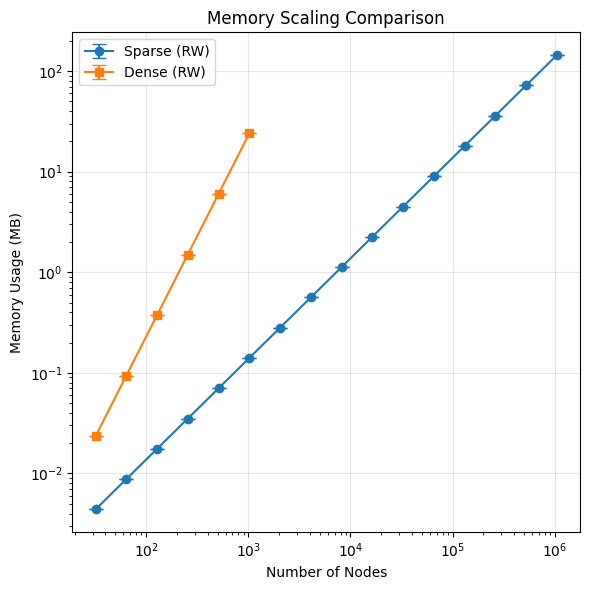

In [19]:
# 1. Memory scaling curve (object size, log-log)
plt.figure(figsize=(6, 6))

# Use sparse_size_mb and dense_size_mb from RW data, or sparse_dense_equiv_mb
if len(df_rw) > 0 and 'n_nodes' in df_rw.columns:
    if 'sparse_size_mb' in df_rw.columns:
        sparse_grouped = df_rw.groupby('n_nodes')['sparse_size_mb'].agg(['mean', 'std']).reset_index()
        plt.errorbar(sparse_grouped['n_nodes'], sparse_grouped['mean'], 
                    yerr=2*sparse_grouped['std'], label='Sparse (RW)', marker='o', capsize=5)
    
    if 'dense_size_mb' in df_rw.columns:
        dense_grouped = df_rw.groupby('n_nodes')['dense_size_mb'].agg(['mean', 'std']).reset_index()
        plt.errorbar(dense_grouped['n_nodes'], dense_grouped['mean'], 
                    yerr=2*dense_grouped['std'], label='Dense (RW)', marker='s', capsize=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Nodes')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Scaling Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

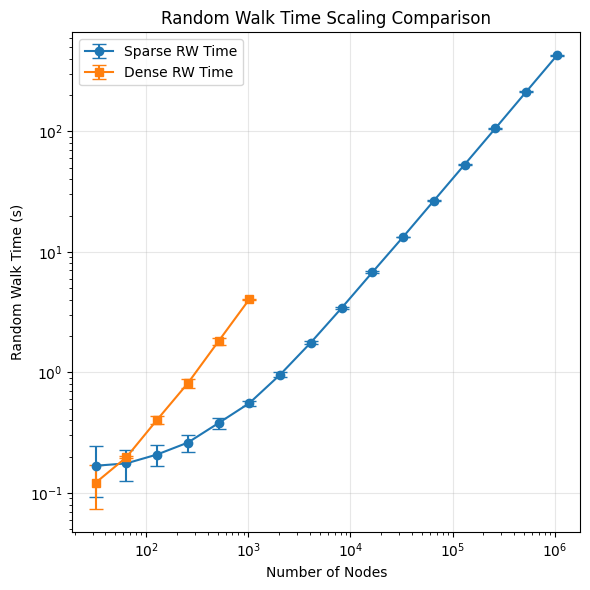

In [20]:
# 2. Kernel init time (rw), log-log
plt.figure(figsize=(6, 6))

# Use sparse_rw_time and dense_rw_time from RW data
if len(df_rw) > 0 and 'n_nodes' in df_rw.columns:
    if 'sparse_rw_time' in df_rw.columns:
        sparse_rw_grouped = df_rw.groupby('n_nodes')['sparse_rw_time'].agg(['mean', 'std']).reset_index()
        plt.errorbar(sparse_rw_grouped['n_nodes'], sparse_rw_grouped['mean'], 
                    yerr=2*sparse_rw_grouped['std'], label='Sparse RW Time', marker='o', capsize=5)
    
    if 'dense_rw_time' in df_rw.columns:
        dense_rw_grouped = df_rw.groupby('n_nodes')['dense_rw_time'].agg(['mean', 'std']).reset_index()
        plt.errorbar(dense_rw_grouped['n_nodes'], dense_rw_grouped['mean'], 
                    yerr=2*dense_rw_grouped['std'], label='Dense RW Time', marker='s', capsize=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Nodes')
plt.ylabel('Random Walk Time (s)')
plt.title('Random Walk Time Scaling Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

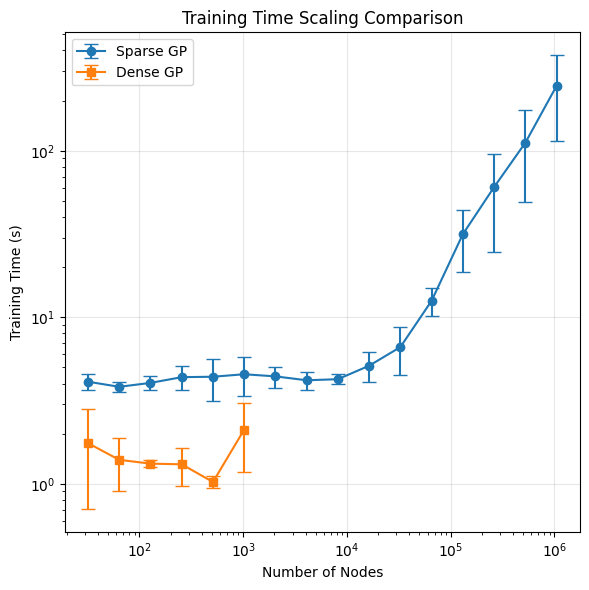

In [21]:
# 3. Training time, log-log
plt.figure(figsize=(6, 6))

if len(df_sparse_gp) > 0 and 'n_nodes' in df_sparse_gp.columns and 'train_time' in df_sparse_gp.columns:
    sparse_grouped = df_sparse_gp.groupby('n_nodes')['train_time'].agg(['mean', 'std']).reset_index()
    plt.errorbar(sparse_grouped['n_nodes'], sparse_grouped['mean'], 
                yerr=2*sparse_grouped['std'], label='Sparse GP', marker='o', capsize=5)

if len(df_dense_gp) > 0 and 'n_nodes' in df_dense_gp.columns and 'train_time' in df_dense_gp.columns:
    dense_grouped = df_dense_gp.groupby('n_nodes')['train_time'].agg(['mean', 'std']).reset_index()
    plt.errorbar(dense_grouped['n_nodes'], dense_grouped['mean'], 
                yerr=2*dense_grouped['std'], label='Dense GP', marker='s', capsize=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Nodes')
plt.ylabel('Training Time (s)')
plt.title('Training Time Scaling Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

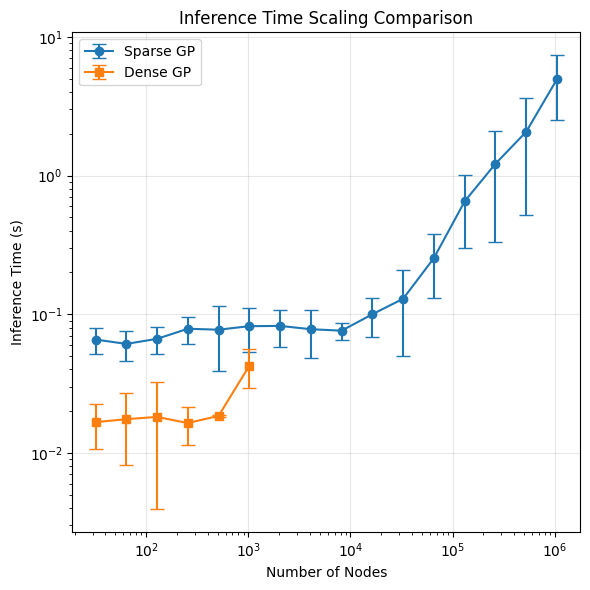

In [22]:
# 4. Inference time, log-log
plt.figure(figsize=(6, 6))

if len(df_sparse_gp) > 0 and 'n_nodes' in df_sparse_gp.columns and 'inference_time' in df_sparse_gp.columns:
    sparse_grouped = df_sparse_gp.groupby('n_nodes')['inference_time'].agg(['mean', 'std']).reset_index()
    plt.errorbar(sparse_grouped['n_nodes'], sparse_grouped['mean'], 
                yerr=2*sparse_grouped['std'], label='Sparse GP', marker='o', capsize=5)

if len(df_dense_gp) > 0 and 'n_nodes' in df_dense_gp.columns and 'inference_time' in df_dense_gp.columns:
    dense_grouped = df_dense_gp.groupby('n_nodes')['inference_time'].agg(['mean', 'std']).reset_index()
    plt.errorbar(dense_grouped['n_nodes'], dense_grouped['mean'], 
                yerr=2*dense_grouped['std'], label='Dense GP', marker='s', capsize=5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Nodes')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Scaling Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()